In [0]:
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab5/im1.jpg
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab5/im2.jpg
!ls

im1.jpg  im2.jpg  sample_data


In [0]:
# Import libraries
from skimage import io
from skimage import exposure
import skimage
from skimage.color import gray2rgb
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
import matplotlib.pyplot as plt
import numpy as np



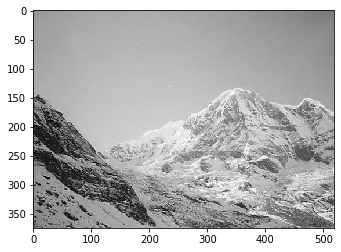

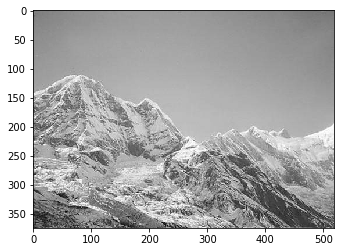

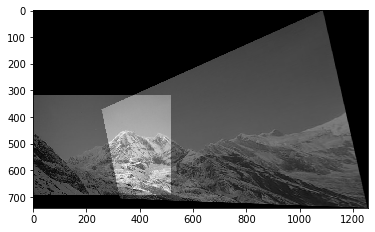

In [0]:
image0 = io.imread('im1.jpg', True)
image1 = io.imread('im2.jpg', True)

plt.imshow(image0,cmap='gray')
plt.show()
plt.imshow(image1,cmap='gray')
plt.show()
#Feature detection and matching

# Initiate ORB detector
# your code #
ORB1 = ORB(n_keypoints=1000)
ORB1.detect_and_extract(image0)


# Find the keypoints and descriptors
# your code #
keypoints1 = ORB1.keypoints
descriptors1 = ORB1.descriptors
ORB1.detect_and_extract(image1)
keypoints2 = ORB1.keypoints
descriptors2 = ORB1.descriptors

# initialize Brute-Force matcher and exclude outliers. See match descriptor function.
# your code #
match12 =  match_descriptors(descriptors1,descriptors2,max_distance = 10,cross_check=True)
src = keypoints2[match12[:,1]][:,::-1]
dst = keypoints1[match12[:,0]][:,::-1]
# Compute homography matrix using ransac and ProjectiveTransform
# your code #
model_robust, inliers = ransac((src, dst),ProjectiveTransform,min_samples=3,
                               residual_threshold=2)
outliers = inliers == False
#Warping
#Next, we produce the panorama itself. The first step is to find the shape of the output image by considering the extents of all warped images.

r, c = image1.shape[:2]

# Note that transformations take coordinates in
# (x, y) format, not (row, column), in order to be
# consistent with most literature.
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions.
warped_corners = model_robust(corners)

# Find the extents of both the reference image and
# the warped target image.
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

#The images are now warped according to the estimated transformation model.

#A shift is added to ensure that both images are visible in their entirety. Note that warp takes the inverse mapping as input.

from skimage.exposure import rescale_intensity
from skimage.transform import warp
from skimage.transform import SimilarityTransform

offset = SimilarityTransform(translation=-corner_min)

image0_ = warp(image0, offset.inverse,
               output_shape=output_shape)

image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape)

#An alpha channel is added to the warped images before merging them into a single image:

def add_alpha(image, background=-1):
    """Add an alpha layer to the image.

    The alpha layer is set to 1 for foreground
    and 0 for background.
    """
    rgb = gray2rgb(image)
    alpha = (image != background)
    return np.dstack((rgb, alpha))


#add alpha to the image0 and image1
#your code
img0 = add_alpha(image0_)
img1 = add_alpha(image1_)


#merge the alpha added image

#your code
merged = (img0+img1)

alpha = merged[..., 3]
merged /= np.maximum(alpha, 1)[..., np.newaxis]
# The summed alpha layers give us an indication of
# how many images were combined to make up each
# pixel.  Divide by the number of images to get
# an average.


#show and save the output image as '/content/gdrive/My Drive/CMPUT 206 Wi19/Lab5_Files/imgOut.png'
#your code

fig, ax = plt.subplots()
ax.imshow(merged,cmap=plt.cm.gray)
plt.show()
# path = "/content/gdrive/My Drive/CMPUT 206 Wi19/Lab5_Files/imgOut.png"
# io.imsave(path,merged)